**<font color=red>İÇERİK TABANLI ÖNERİ SİSTEMİ - CONTENT-BASE RECOMMENDATION SYSTEM**

Bigbasket, Hindistan'ın en büyük çevrimiçi süpermarketidir. Bu markeetteki verilere göre müşterilere almış oldukları ürünlere benzer, farklı ürünleri tavsiye edeceğiz

In [90]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings
filterwarnings("ignore")

In [77]:
df = pd.read_csv("BigBasket Products.csv")
df.head(3)

,index,product,category,sub_category,brand,sale_price,market_price,type,rating,description
0,1,Garlic Oil - Vegetarian Capsule 500 mg,Beauty & Hygiene,Hair Care,Sri Sri Ayurveda,220.0,220.0,Hair Oil & Serum,4.1,This Product contains Garlic Oil that is known...
1,2,Water Bottle - Orange,"Kitchen, Garden & Pets",Storage & Accessories,Mastercook,180.0,180.0,Water & Fridge Bottles,2.3,"Each product is microwave safe (without lid), ..."
2,3,"Brass Angle Deep - Plain, No.2",Cleaning & Household,Pooja Needs,Trm,119.0,250.0,Lamp & Lamp Oil,3.4,"A perfect gift for all occasions, be it your m..."


In [78]:
df.shape

(27555, 10)

In [79]:
df.isnull().sum()

index              0
product            1
category           0
sub_category       0
brand              1
sale_price         0
market_price       0
type               0
rating          8626
description      115
dtype: int64

In [93]:
# product sutununda ki benzersiz değerler
df["product"].nunique()

23540

In [95]:
# product sutunundaki değerlerin kaç defa geçtiği

df["product"].value_counts().sort_values(ascending=False)[:10]

product
Turmeric Powder/Arisina Pudi          26
Extra Virgin Olive Oil                15
Cow Ghee/Tuppa                        14
Soft Drink                            12
Colorsilk Hair Colour With Keratin    12
Olive Oil - Extra Virgin              12
Coriander Powder                      11
Powder - Coriander                    11
Ghee/Tuppa                            11
Peanut Butter - Creamy                10
Name: count, dtype: int64

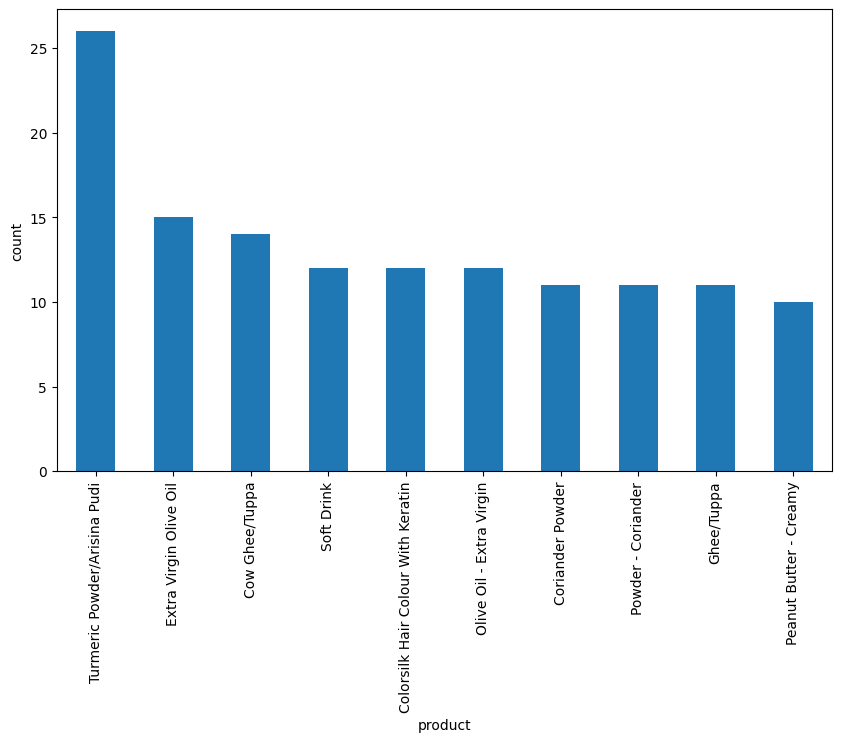

In [107]:
viz = df["product"].value_counts().sort_values(ascending=False)[:10]
plt.figure(figsize=(10,6))
viz.plot(kind="bar")
plt.xlabel("product")
plt.ylabel("count")
plt.show()

In [102]:
# en yüksek puanlanmış ilk 5 ürün

df.groupby("product")["rating"].max().sort_values(ascending=False)[:5]

product
Man - Green Eau De Toilette Deodorant       5.0
Organic Powder - Wheat Grass                5.0
Organic Penne - Rigate                      5.0
Baby Moments Soap                           5.0
Baby Moisturising Wash Cleansing Therapy    5.0
Name: rating, dtype: float64

In [89]:
# kaç adet benzersiz ürün var

df["category"].nunique()

11

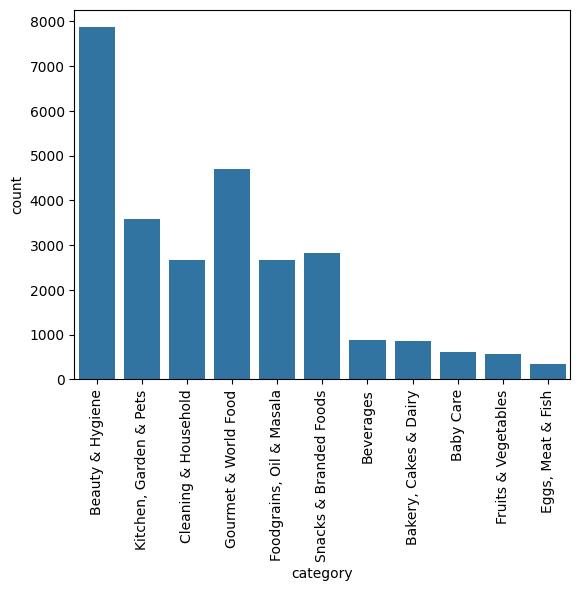

In [109]:
# category sutunundaki değerlerin görselleştirilmesi
sns.countplot(data=df,x="category")
plt.xticks(rotation=90);

In [92]:
# sub_category sutununda ki benzersiz değerler

df["sub_category"].nunique()

90

In [80]:
# product ve description sutununu kullanacağım
df1 = df[["product","description"]]
df1.head(3)

,product,description
0,Garlic Oil - Vegetarian Capsule 500 mg,This Product contains Garlic Oil that is known...
1,Water Bottle - Orange,"Each product is microwave safe (without lid), ..."
2,"Brass Angle Deep - Plain, No.2","A perfect gift for all occasions, be it your m..."


In [81]:
# eksik değerleri siliyorum
# Tekrar eden değerleri listeden çıkarıyorum
# indexi resetliyorum

df1.dropna(inplace=True)
df1.drop_duplicates(subset=["product"],inplace=True)
df1.reset_index(drop=True,inplace=True)
df1.shape

(23449, 2)

In [82]:
# ürünlerimizi tanımlayan kelimeleri ve sıklıklarını hesaplıyoruz.Benzerliklerini anlayabilmemiz için Matrix dönüşümü uyguluyoruz

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words="english")
tfidf_matrix = tfidf.fit_transform(df1["description"])

In [83]:
# Cosine Benzerliğini kullanarak benzerlik puanlarımızı bulacağız

from sklearn.metrics.pairwise import linear_kernel

cosine_sim = linear_kernel(tfidf_matrix,tfidf_matrix)
cosine_sim[:3]

array([[1.        , 0.01581616, 0.01010667, ..., 0.        , 0.01081356,
        0.01125186],
       [0.01581616, 1.        , 0.00707568, ..., 0.        , 0.        ,
        0.        ],
       [0.01010667, 0.00707568, 1.        , ..., 0.01489946, 0.00638969,
        0.        ]])

In [84]:
# indexlerin ve ürün/film başlıklarının ters haritasını oluşturuyoruz.
indices = pd.Series(df1.index, index=df1["product"])
indices

product
Garlic Oil - Vegetarian Capsule 500 mg                         0
Water Bottle - Orange                                          1
Brass Angle Deep - Plain, No.2                                 2
Cereal Flip Lid Container/Storage Jar - Assorted Colour        3
Creme Soft Soap - For Hands & Body                             4
                                                           ...  
Toilet Cleaning Brush - Round With Holder (Big)            23444
Organic Powder - Garam Masala                              23445
Wottagirl! Perfume Spray - Heaven, Classic                 23446
Peri-Peri Sweet Potato Chips                               23447
Green Tea - Pure Original                                  23448
Length: 23449, dtype: int64

In [85]:
# Bu fonksiyon ile fonksiyona göndermiş olduğumuz ürüne/filme en yakın benzerlikte ki 10 ürünü/filmi geri döndürecek

def get_recommendations(title, cosine_sim=cosine_sim):
    # Girilen ürünün/filmin indeksini al
    idx = indices[title]

    # Bu ürünün/filmin diğer tüm ürünlerle/filmlerle olan benzerlik puanlarını listele
    sim_scores = list(enumerate(cosine_sim[idx]))

    # ürünleri/filmleri benzerlik puanlarına göre sırala
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # En çok benzeyen 10 ürünün/filmin skorunu al
    sim_scores = sim_scores[1:11]

    # ürün/Film indekslerini al
    product_indices = [i[0] for i in sim_scores]

    # En çok benzeyen 10 ürünü/filmi döndür
    return df1['product'].iloc[product_indices]

In [86]:
get_recommendations('Rosemary')

5708                                      Rosemary Shampoo
3492                                       Rosemary Hummus
8745                           Rosemary Pure Essential Oil
19559                                 Rosemary Conditioner
14278                    Rosemary Pure Aroma Essential Oil
11182    Cold Pressed Rosemary Lavender Healthy Hair Oi...
7100                                Rosemary Essential Oil
7116                    Rosemary - Organic, USDA Certified
9891                             Organic Cumin Seed Powder
11520                                 Energy Essential Oil
Name: product, dtype: object